#### _NN HW3_ _([from Deep Learning - ANN - Part 1.3 Sol.ipynb](https://github.com/rklepov/hse-cs-ml-2018-2019/blob/homework/05-NN/02-ann/Deep%20Learning%20-%20ANN%20-%20Part%201.3%20Sol.ipynb))_

Задача опредления вероятности дефолта (неуплаты долга) по кредитной карте

https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset

* Постройте классификатор на основе полносвязной нейронной сети для определения вероятности дефолта по кредитной карте (невозврат долга).

* Экземляров данных довольно мало, поэтому не нужно упорствовать с увеличением глубины и ширины сети

* Обязательное кодирование категориальных признаков

* Обязательная стандартизация или масштабирование признаков

* Если применяете One Hot Encoding (бинарное кодирование), то обратите внимание на регуляризацию, чтобы предотвратить переобучение

* Постройте классификатор на основе автоэнкодера для решения этой же задачи аналогично примеру с мошенничествам по картам

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, classification_report,
                             roc_curve, precision_recall_curve,
                             confusion_matrix)

from keras import regularizers
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Activation, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [32]:
import sys
print(f'python {sys.version}')
import tensorflow as tf
print(f'tensorflow {tf.__version__}')
import keras
print(f'keras {keras.__version__}')

python 3.6.8 |Anaconda custom (64-bit)| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]
tensorflow 1.13.1
keras 2.2.4


# 1. Data preparation

In [33]:
uci = pd.read_csv('UCI_Credit_Card.csv')

uci.shape

(30000, 25)

In [34]:
uci.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null float64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null float64
BILL_AMT2                     30000 non-null float64
BILL_AMT3                     30000 non-null float64
BILL_AMT4                     30000 non-null float64
BILL_AMT5                     30000 non-null float64
BILL_AMT6   

In [35]:
uci.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0


In [36]:
uci.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [37]:
uci['default.payment.next.month'].value_counts()

0    23364
1     6636
Name: default.payment.next.month, dtype: int64

## 1.2 Encoding

Кодируем категориальные признаки с помощью **OHE**.

In [38]:
uci = pd.get_dummies(uci, drop_first=True, columns=['SEX', 'EDUCATION', 'MARRIAGE'])

In [39]:
X_train, X_test, y_train, y_test = train_test_split(uci.drop('default.payment.next.month', 1),
                                                    uci['default.payment.next.month'],
                                                    stratify=uci['default.payment.next.month'],
                                                    test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24000, 31), (6000, 31), (24000,), (6000,))

## 1.3. Scaling

In [40]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

C:\Users\roma\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\roma\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\roma\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


# 2. ANN classifier

Для регуляризации используем **[Dropout](https://keras.io/layers/core/)**

In [41]:
model = Sequential()
model.add(Dense(40, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics={'roc_auc' : metrics.roc_auc_score})

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 40)                1280      
_________________________________________________________________
dropout_3 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 30)                1230      
_________________________________________________________________
dropout_4 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 31        
Total params: 2,541
Trainable params: 2,541
Non-trainable params: 0
_________________________________________________________________


In [42]:
%%time

history = model.fit(X_train, y_train,
                    batch_size=500,
                    epochs=75,
                    verbose=0,
                    validation_data=(X_test, y_test))

Wall time: 12.7 s


In [43]:
y_probs = model.predict_proba(X_test)
y_pred = (y_probs.flatten() > 0.5) * 1

### _2.1 Quality metrics_

In [44]:
def plot_curve_xy(x, y):    
    plt.plot(x, y, lw=3)

def plot_curve(nrc, curve, y_test, y_probs, title, xlabel, ylabel):
    plt.subplot(nrc)
    auc = curve(y_test, y_probs)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f'{title} AUC={auc:.3f}')
    plt.grid()

def plot_roc_curve(y_test, y_probs):
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    plot_curve_xy(fpr, tpr)
    return metrics.auc(fpr, tpr)

def plot_pr_curve(y_test, y_probs):
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    plot_curve_xy(recall, precision)
    return metrics.auc(recall, precision)

In [45]:
print( classification_report(y_test, y_pred) )
print(f'ROC AUC = {roc_auc_score(y_test, y_probs):.4f}')

              precision    recall  f1-score   support

           0       0.82      0.96      0.89      4673
           1       0.67      0.27      0.39      1327

   micro avg       0.81      0.81      0.81      6000
   macro avg       0.75      0.62      0.64      6000
weighted avg       0.79      0.81      0.78      6000

ROC AUC = 0.7372


#### _ROC and Precision/Recall curves_ 

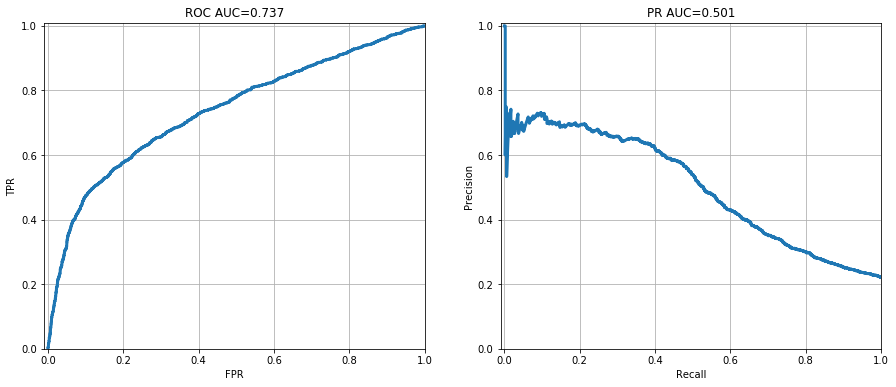

In [46]:
plt.figure(figsize=(15, 6))

plot_curve(121, plot_roc_curve, y_test, y_probs, 'ROC', 'FPR', 'TPR')
plot_curve(122, plot_pr_curve, y_test, y_probs, 'PR', 'Recall', 'Precision')

plt.show();

# 3. Autoencoder classifier

\* сразу хочу отметить, что мне не удалось реализовать эффективной модели предсказания с помощью автоэнкодера.

In [47]:
np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int64), array([18691,  5309], dtype=int64))

Обучаем на одном классе, чтобы потом на тесте второй класс выделялся как аномалия.

In [48]:
X_train_ae = X_train[y_train < 1]

X_train_ae.shape

(18691, 31)

In [49]:
input_dim = X_train.shape[1]
encoding_dim = 16

# структура сети аналогична примеру из ноутбука с лекции
# 'Deep Learning - ANN - Part 1.3 Sol.ipynb' п.3.3
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation='tanh', 
                activity_regularizer=regularizers.l1(0.0005))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation='relu')(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [50]:
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics={'r2_score' :  metrics.r2_score})

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 31)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                512       
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_14 (Dense)             (None, 31)                279       
Total params: 999
Trainable params: 999
Non-trainable params: 0
_________________________________________________________________


In [51]:
%%time

checkpointer = ModelCheckpoint(filepath="uci_autoencoder.h5", verbose=0, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

hist = autoencoder.fit(X_train_ae, X_train_ae, epochs=100, batch_size=32,
                       shuffle=True, validation_data=(X_test, X_test),
                       callbacks=[checkpointer, early_stopping], verbose=0)

Wall time: 1min 4s


In [52]:
autoencoder = load_model('uci_autoencoder.h5', custom_objects={'r2_score' : metrics.r2_score})

In [53]:
predictions = autoencoder.predict(X_test)

reconstruction_mse = np.mean(np.power(X_test - predictions, 2), axis=1)

### _5.1 Quality metrics_

#### _Распределение MSE по классам_

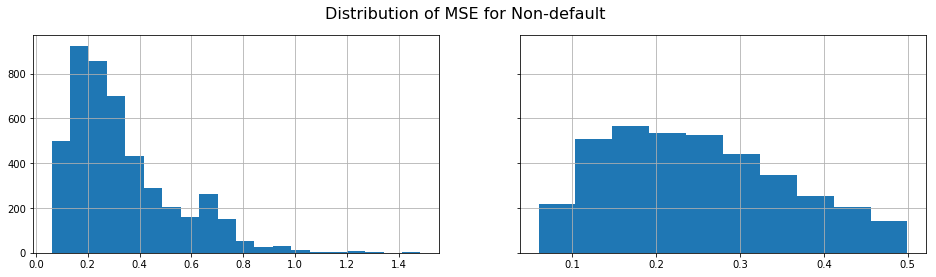

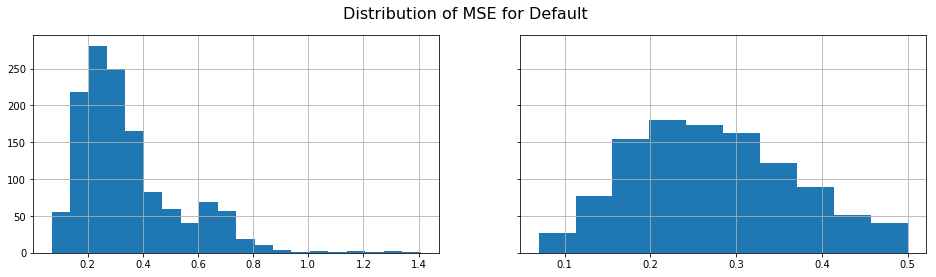

In [54]:
def plot_mse_hist(ax, mse, where, bins=20):
    ax.hist(mse[where], bins)
    ax.grid()
    return ax

fig, ax = plt.subplots(1, 2, sharey='row', figsize=(16, 4))
fig.suptitle('Distribution of MSE for Non-default', fontsize=16)
plot_mse_hist(ax[0], reconstruction_mse, (y_test < 1) & (reconstruction_mse < 1.5))
plot_mse_hist(ax[1], reconstruction_mse, (y_test < 1) & (reconstruction_mse < 0.5), bins=10)

fig, ax = plt.subplots(1, 2, sharey='row', figsize=(16, 4))
fig.suptitle('Distribution of MSE for Default', fontsize=16)
plot_mse_hist(ax[0], reconstruction_mse, (y_test > 0) & (reconstruction_mse < 1.5))
plot_mse_hist(ax[1], reconstruction_mse, (y_test > 0) & (reconstruction_mse < 0.5), bins=10)

Как можно видеть, существенного отличия ошибки на позитивном классе не выявляется.

#### _ROC and Precision/Recall curves_

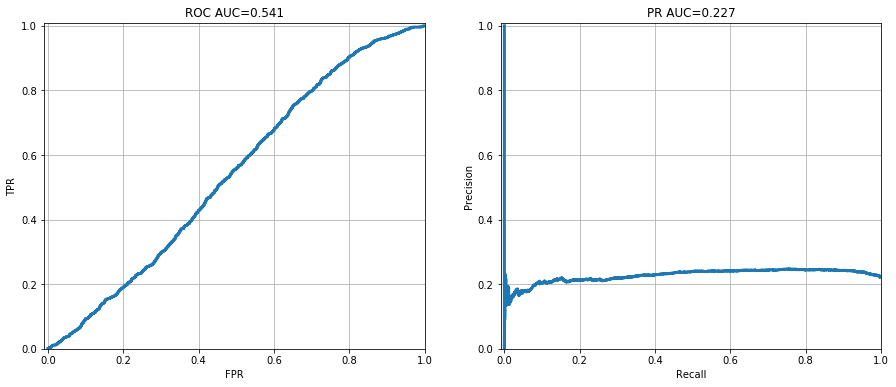

In [55]:
plt.figure(figsize=(15, 6))

plot_curve(121, plot_roc_curve, y_test, reconstruction_mse, 'ROC', 'FPR', 'TPR')
plot_curve(122, plot_pr_curve,  y_test, reconstruction_mse, 'PR', 'Recall', 'Precision')

plt.show();

ROC-AUC низкий, PR-AUC вообще никакой.

### _5.1 Prediction_

In [56]:
threshold = 0.28

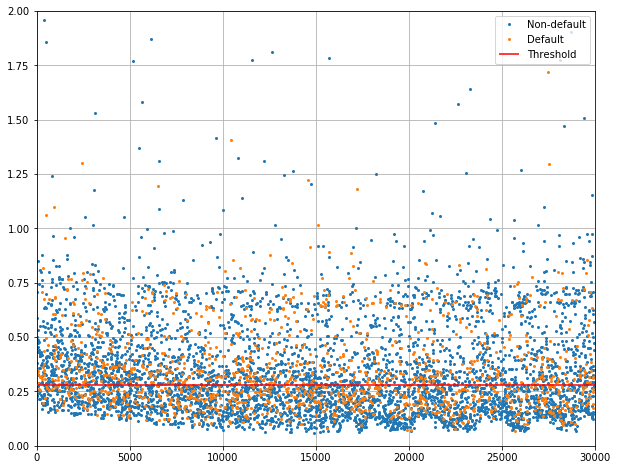

In [57]:
plt.figure(figsize=(10, 8))

plt.plot(y_test.index[y_test < 1], reconstruction_mse[y_test < 1], marker='o', ms=2, linestyle='', label='Non-default')
plt.plot(y_test.index[y_test > 0], reconstruction_mse[y_test > 0], marker='o', ms=2, linestyle='', label='Default')
plt.ylim(0, 2)
plt.xlim(min(y_test.index), max(y_test.index))
plt.hlines(threshold, plt.xlim()[0], plt.xlim()[1], color="r", zorder=100, label='Threshold')
plt.grid()
plt.legend();

In [58]:
y_pred = [ 1 if e > threshold else 0 for e in reconstruction_mse ]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.50      0.62      4673
           1       0.24      0.55      0.34      1327

   micro avg       0.52      0.52      0.52      6000
   macro avg       0.52      0.53      0.48      6000
weighted avg       0.68      0.52      0.56      6000



#### _Confusion matrix_ 

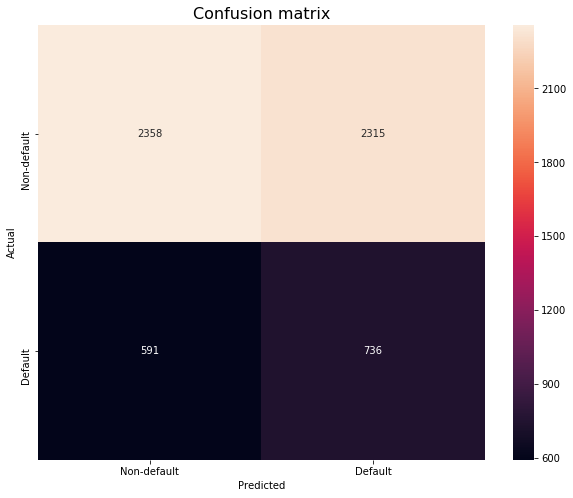

In [59]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
labels = ['Non-default', 'Default']
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt='d');
plt.title("Confusion matrix", fontsize=16)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show();

Как и было отмечено выше, точность невысокая, большое число _false positives_.